In [ ]:
# Source code for "Predictive water turbidity monitoring using computer vision". J. Villamil, J. Victorino, F. Gómez.
# Francisco Gómez J PhD
# Universidad Nacional de Colombia
# Departamento de Matemáticas
# 2021

# Image quality measures

Computes the image quality measurements

In [13]:
from PIL import Image 
from PIL import ImageChops 
from collections import defaultdict
import os
import numpy as np
import math
import matplotlib.pyplot as plt


# Computes the image variance
def _get_variance(color_count: dict, average: float):
    """
    Compute the variance
    :param color_count: Number of each color in the tile
    :param average: Average pixel color in the tile
    :return: Variance
    """
    variance = 0.0
    for pixel in color_count:
        a = pixel - average
        variance += color_count[pixel] * a * a
    return variance

# Get the SSIM quality descriptor
def get_ssim_sum(image_0, image_1, tile_size, pixel_len, width, height, c_1, c_2):
    """
    Get intermediate SSIM result using CPU
    :param image_0: First image
    :param image_1: Second image
    :param tile_size: Width/ height of image subsections(tiles)
    :param pixel_len: Number of pixels in the tiles
    :param width: Image width
    :param height: Image height
    :param c_1: Constant 1
    :param c_2: Constant 2
    :return: Intermediate SSIM result
    """
    channels = range(len(image_0.mode))
    ssim_sum = 0.0
    ssim_sumLum = 0.0
    ssim_sumCont = 0.0
    

    for x in range(0, width, tile_size):
        for y in range(0, height, tile_size):

            # Get pixel tile
            box = (x, y, x + 7, y + 7)
            tile_0 = image_0.crop(box)
            tile_1 = image_1.crop(box)

            for i in channels:
                # Tile
                pixel0, pixel1 = tile_0.getdata(band=i), tile_1.getdata(band=i)
                color_count_0 = defaultdict(int)
                color_count_1 = defaultdict(int)
                covariance = 0.0

                for i1, i2 in zip(pixel0, pixel1):
                    color_count_0[i1] += 1
                    color_count_1[i2] += 1
                    covariance += i1 * i2

                pixel_sum_0 = sum(pixel0)
                pixel_sum_1 = sum(pixel1)
                average_0 = pixel_sum_0 / pixel_len
                average_1 = pixel_sum_1 / pixel_len

                covariance = (covariance - pixel_sum_0 * pixel_sum_1 / pixel_len) / pixel_len
                # Calculate the sum of both image's variances
                variance_0_1  = _get_variance(color_count_0, average_0)
                variance_0_1 += _get_variance(color_count_1, average_1)
                variance_0_1 /= pixel_len
                
                lum = (2.0 * average_0 * average_1 + c_1)/(average_0 * average_0 + average_1 * average_1 + c_1)
                cont = (2.0 * covariance + c_2)/(variance_0_1 + c_2)
                ssim_sumLum += lum
                ssim_sumCont += cont
                
                ssim_sum += lum*cont

    vectOut = np.array([ssim_sum,ssim_sumLum])
        
    return vectOut

# Computes the structural similarity index
def structuralSimilarityIndices(image_0, image_1, tile_size = 7):
    """
    Compute the structural similarity between the two images.
    :param image_0: PIL Image object
    :param image_1: PIL Image object
    :param tile_size: Height and width of the image's sub-sections used
    :return: Structural similarity value
    """
    # constants
    dynamic_range = 255
    c_1 = (dynamic_range * 0.01) ** 2
    c_2 = (dynamic_range * 0.03) ** 2
    pixel_len = tile_size * tile_size
    width, height = image_0.size
    width = width // tile_size * tile_size
    height = height // tile_size * tile_size

    # Verify input parameters
    if image_0.size != image_1.size:
        raise AttributeError('The images do not have the same resolution')
    # no else
    if image_0.mode != image_1.mode:
        raise AttributeError('The images have different color channels')
    # no else
    if width < tile_size or height < tile_size:
        raise AttributeError('The images are smaller than the window_size')
        
    valRet = get_ssim_sum(image_0, image_1, tile_size, pixel_len, width, height, c_1, c_2) * pixel_len / (len(image_0.mode) * width * height)
    return valRet
  
# Computes the PSNR and the MSE
def PSNR_RMSE(original, compressed):
    original = np.asarray(original)
    compressed = np.asarray(compressed)    
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse)) 
    return psnr,math.sqrt(mse)    

# Computes the image quality
def compute_quality(im1, im2):
    """Calculates the root mean square error (RSME) between two images"""
    psnr,rmse = PSNR_RMSE(im1,im2)
    ssimi = structuralSimilarityIndices(im1,im2,30)
    return [psnr,rmse] + ssimi.tolist()

# Obtains the image quality values
def getQualityValues(dirImg,getImgs=False):
    """Computes the image quality values for a complete configuration"""
    filesImgs = os.listdir(dirImg)
    imRef = Image.open(dirImg + '/' + filesImgs[0])    
    valuesQuality = []
    imagesList = []

    if getImgs==True:
        imagesList.append(plt.imread(dirImg + '/' + filesImgs[0]))
    
    for i in range(2,len(filesImgs)):
        pathImg = dirImg + '/' + filesImgs[i]
        imTurb = Image.open(pathImg)
        if getImgs==True:
            imagesList.append(plt.imread(pathImg))

        values = compute_quality(imRef,imTurb)
        valuesQuality.append(values)

    if getImgs==True:
        return valuesQuality,imagesList
    else:
        return valuesQuality

# Extracts the vector with the reference values
def getReferenceValues(dirImg):
    """Computes a vector with the vector of reference values"""
    filesImgs = os.listdir(dirImg)
    
    vecRef = []
    for i in range(2,len(filesImgs)):
        vecRef.append(float(filesImgs[i].split('_')[0]))
    
    return vecRef

# Compute predictive error in one dataset using ML (Linear predictors) 

Computes training, validation (model comparison) and prediction on non-previously observed samples.

SecchiDisk linear
Mean error: 4.33
Standard deviation error: 3.28
SecchiDisk linear
Mean error: 2.74
Standard deviation error: 1.08
Square linear
Mean error: 0.88
Standard deviation error: 0.44
SecchiDisk linear
Mean error: 0.93
Standard deviation error: 0.62


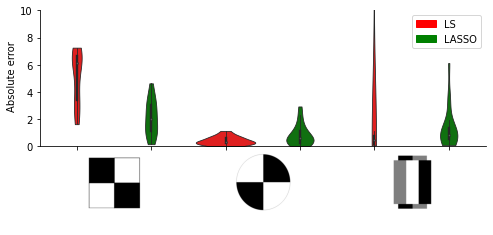

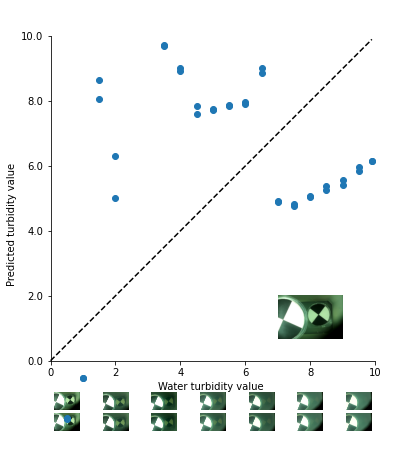

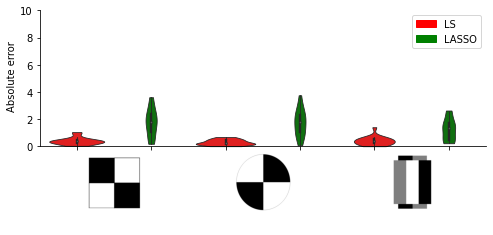

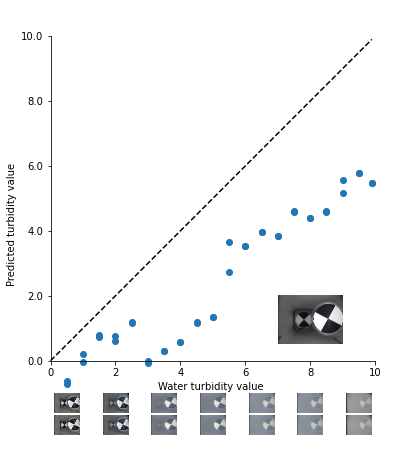

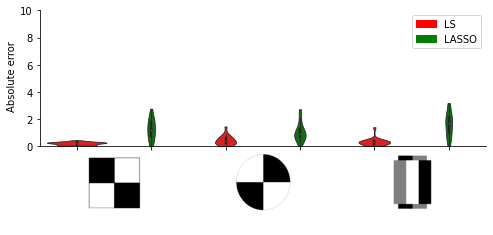

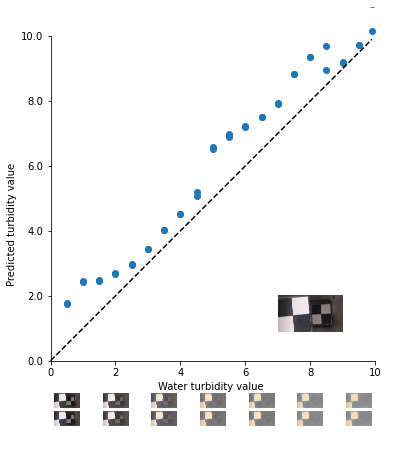

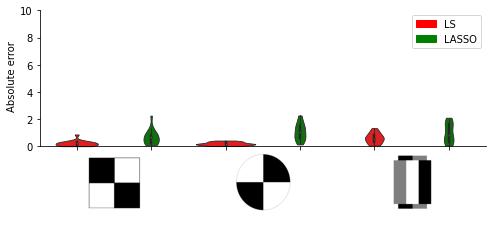

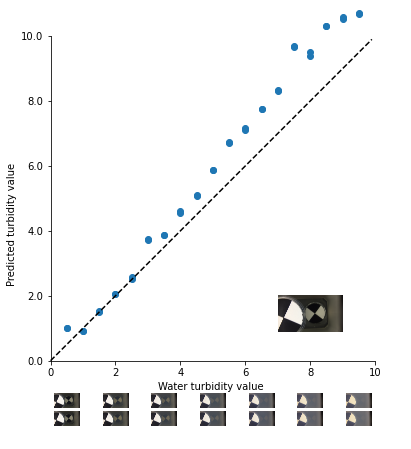

In [12]:
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline  

# Compute the performance measure for the predictions
def computePerformanceMeasure(refValue,predValue):
    """Computes the performance measurements of prediction"""    
    vecDiff = abs(refValue-predValue)
    return vecDiff


# Compute the generalization error
def computeGeneralizationError(pattern,device):
    """Computes the generalization training process and model comparison on validation data"""    
    configName = pattern+'_'+device
    # Train two ML linear models
    # Train a linear model
    fullNameDBTrain = "DBturbidity/" + configName + "_train/"
    trainXData = getQualityValues(fullNameDBTrain)
    trainYData = getReferenceValues(fullNameDBTrain)

    modelLinear = linear_model.LinearRegression()
    modelLinear.fit(trainXData,trainYData)

    # Train a LASSO model
    modelLasso = linear_model.Lasso(alpha=0.1)
    modelLasso.fit(trainXData,trainYData)
    
    # Valide the models
    fullNameDBVali = "DBturbidity/" + configName + "_validation/"
    # Compute the validation model
    valiXData = getQualityValues(fullNameDBVali)
    valiYData = getReferenceValues(fullNameDBVali)
    yPredictionValiLinear = modelLinear.predict(valiXData)
    yPredictionValiLasso = modelLasso.predict(valiXData)
    
    errorValiLinear = computePerformanceMeasure(valiYData,yPredictionValiLinear)
    errorValiLasso = computePerformanceMeasure(valiYData,yPredictionValiLasso)
    
    return errorValiLinear,errorValiLasso

# Obtain predictions
def getPrediction(pattern,device,winModel):
    """Computes predictions on test data - non-previously observed data""" 
    configName = pattern+'_'+device    
    # Get all the avaliable data to train the model to be used in prediction
    fullNameDBTrain = "DBturbidity/" + configName + "_train/"
    trainXData = getQualityValues(fullNameDBTrain)
    trainYData = getReferenceValues(fullNameDBTrain)
    
    fullNameDBVali = "DBturbidity/" + configName + "_validation/"
    # Compute the validation model
    valiXData = getQualityValues(fullNameDBVali)
    valiYData = getReferenceValues(fullNameDBVali)
    
    fullTrainXData = trainXData + valiXData
    fullTrainYData = trainYData + valiYData

    configNameTest = pattern+'_'+device
    fullNameDBTest = "DBturbidity/" + configNameTest + "_test/"
    # Predict using the models already adjusted
    testYData = getReferenceValues(fullNameDBTest)
    testXData,listImgsTest = getQualityValues(fullNameDBTest,getImgs=True)
    
    modelPredict = None
    if winModel == "linear":
        modelPredict = linear_model.LinearRegression()
        modelPredict.fit(fullTrainXData,fullTrainYData)
    elif winModel == "lasso":
        modelPredict = linear_model.Lasso(alpha=0.1)
        modelPredict.fit(fullTrainXData,fullTrainYData)

    yPrediction = modelPredict.predict(testXData)
        
    errorPrediction = computePerformanceMeasure(testYData,yPrediction)
    
    return testYData,yPrediction,listImgsTest


def plotFigureError(dataError):
    """Plot the figure of validation error """ 
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    
    plt.ylim(bottom=-6, top=10)

    ax.spines['left'].set_position(('data', -0.5))
    ax.spines['left'].set_bounds((0,10))
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    red_patch = mpatches.Patch(color='red', label='LS')
    green_patch = mpatches.Patch(color='green', label='LASSO')
    plt.legend(handles=[red_patch,green_patch])    

    plt.ylabel('Absolute error')
    ax.get_yaxis().set_label_coords(-0.05,0.7)
    
    
    patSquare = plt.imread('Patterns/square.png')
    patSecchi = plt.imread('Patterns/secchiDisk.png')
    patSecchi3000 = plt.imread('Patterns/secchi3000.png')
    plt.imshow(patSquare,extent=(0.1,.9,-5.0,-0.5),aspect='auto')
    plt.imshow(patSecchi,extent=(2.1,2.9,-5.0,-0.5),aspect='auto')
    plt.imshow(patSecchi3000,extent=(4.1,4.9,-5.0,-0.5),aspect='auto')
    
    sns.violinplot(data=dataError.T,palette=['r','g','r','g','r','g'],split=True,cut=0,linewidth=0.8)
    ax.set_xticklabels([])
    
    ticks = [0,2,4,6,8,10]
    ax.set_yticks(ticks)

    dic = { 1.0 : ""}
    labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]

    ax.set_yticklabels(labels)
    

def plotFigurePrediction(xwin,ywin,label,listImgsTest):
    """Plot the figure with predictions """ 
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.scatter(xwin,ywin)
    ax.plot([0,xwin[-1]],[0,xwin[-1]],linestyle='--',color='k')
    plt.xlabel('Water turbidity value')
    plt.ylabel('Predicted turbidity value')
    plt.xlim(-1,xwin[-1]+1)
    plt.ylim(-2.5,xwin[-1]+1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(label)
    ax.spines['left'].set_position(('data', 0))
    ax.spines['left'].set_bounds((0,10))
    ax.spines['bottom'].set_position('zero')
    ax.spines['bottom'].set_bounds((0,10))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ticks = [0.0,2.0,4.0,6.0,8.0,10.0]
    ax.set_yticks(ticks)

    dic = { 1.0 : ""}
    labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]

    ax.set_yticklabels(labels)


    wImg = 2
    wImgOrig = (len(listImgsTest[0][0]))
    hImgOrig = (len(listImgsTest[0]))
    hImg = wImg*hImgOrig/wImgOrig
    ypos = 2
    xpos = 8
    
    plt.imshow(listImgsTest[0],extent=(xpos-wImg/2, xpos+wImg/2, ypos, ypos-hImg))

    for i in range(0,len(listImgsTest),2):
        wImg = 0.8
        ypos = -1
        wImgOrig = (len(listImgsTest[0][0]))
        hImgOrig = (len(listImgsTest[0]))
        hImg = wImg*hImgOrig/wImgOrig
            
        if i%3 == 0:
            plt.imshow(listImgsTest[i+1],extent=(xwin[i]-wImg/2,  xwin[i]+wImg/2, ypos, ypos-hImg))
            plt.imshow(listImgsTest[i+2],extent=(xwin[i]-wImg/2,  xwin[i]+wImg/2, ypos-hImg-0.1, ypos-2*hImg-0.1))
    

vecDevices = ['dev1','dev2','dev3','dev4']
vecPatterns = ['Square','SecchiDisk','Secchi3000']

for idev in vecDevices:
    vecErrorsValidation = []

    for iPattern in vecPatterns:
        errorValiLinear,errorValiLasso = computeGeneralizationError(iPattern,idev)
        vecErrorsValidation.append(errorValiLinear)
        vecErrorsValidation.append(errorValiLasso)

    vecErrorsValidationNP = np.array(vecErrorsValidation)
    plotFigureError(vecErrorsValidationNP)
    # Compute the best model
    vMean = np.mean(vecErrorsValidationNP,1)
    winModel = np.argmin(vMean)

    if (winModel//2)==0:
        modelWinPattern = 'Square' 
    elif (winModel//2)==1:
        modelWinPattern = 'SecchiDisk'
    elif (winModel//2)==2:
        modelWinPattern = 'Secchi3000'

    if (winModel%2)==0:
        predModel = 'linear'
    else:
        predModel = 'lasso'

    testYData,yPrediction,listImgsTest = getPrediction(modelWinPattern,idev,'linear')
    print(modelWinPattern + " " + predModel)
    plotFigurePrediction(testYData,yPrediction,"",listImgsTest)
    print('Mean error:',round(np.mean(abs(testYData-yPrediction)),2))
    print('Standard deviation error:',round(np.std(abs(testYData-yPrediction)),2))
